# PreBotC model

In [1]:
from brian2 import *
import numpy as np
import pickle
set_device('cpp_standalone') #, build_on_run=False
start_scope()

def plot_vars(statemon, rate, n, m, show_variables = True):
    figure(figsize=(16,4))
    plot(statemon.t[int(duration*n*10):int(duration*m*10)]/ms, rate.smooth_rate(window='gaussian', width= 30*ms)[int(duration*n*10):int(duration*m*10)])
    xlabel('time (ms)')
    ylabel('Firing Rate')
    ylim([0,1.5*np.max(rate.smooth_rate(window='gaussian', width= 30*ms)[int(duration*n*10):int(duration*m*10)]/Hz)])
    plt.grid(True)
    plt.minorticks_on()
    
    
    show()
    
    if show_variables:
        list_of_params = statemon.record_variables
        for i in range(len(list_of_params)):
            figure(figsize=(16,4))
            plot(statemon.t[int(duration*n*10):int(duration*m*10)]/ms, eval('statemon.'+str(statemon.record_variables[i]))[0][int(duration*n*10):int(duration*m*10)])
            xlabel('time (ms)')
            ylabel(str(list_of_params[i]))
            # ylim([0,60])
            plt.grid(True)
            plt.minorticks_on()
            show()
    

In [2]:
eqs_adaptive = '''
du/dt = a*((b/mV)*v - u)/(1*ms) : 1

dv/dt = ( alpha*(v - U0)**2 /(mV) + Ubase - x*u*mV  - IsynE - IsynI)/(1*ms)  : volt # - (INaP)
alpha = 0.0125/3 : 1
U0 = -62.5*mV : volt
Ubase = -0*mV :volt
x = 0.06 : 1
a = 0.001/2 : 1 # interburst interval. The lesser the a, the greater IBI
b = 0.0: 1

IsynE = (gE*wE + g_Edrive)*(v - v_synE): volt
gE = 0.1/3 : 1
g_Edrive = 0.1*(y) : 1 #exitatory drive #1*t/60000/ms
y : 1
v_synE = -10*mV : volt
dwE/dt = -wE/tauE : 1
tauE = 10*ms : second

IsynI = gE*(wI_1 + wI_2 + wI_3)*(v - v_synI): volt
gI = 1 : 1
v_synI = -75*mV : volt
dwI_1/dt = -wI_1/tauI : 1
dwI_2/dt = -wI_2/tauI : 1
dwI_3/dt = -wI_3/tauI : 1
tauI = 15*ms : second
c = -55*mV   : volt 
d : 1
'''

eqs_bursting = '''
du/dt = a*((b/mV)*v - u)/(1*ms) : 1

dv/dt = ( alpha*(v - U0)**2 /(mV) + Ubase - 0.1*u*mV  - IsynE - IsynI)/(1*ms)  : volt # - (INaP)
alpha = 0.004 : 1
U0 = -62.5*mV : volt
Ubase = -1.6*mV :volt
a = 0.001 : 1 # interburst interval. The lesser the a, the greater IBI
b = 0.2: 1

IsynE = (gE*wE + g_Edrive)*(v - v_synE): volt
gE = 0.1 : 1
y : 1
g_Edrive = 0.1*(y) : 1 #exitatory drive #1*t/60000/ms
v_synE = -10*mV : volt
dwE/dt = -wE/tauE : 1
tauE = 10*ms : second

IsynI = gE*(wI_1 + wI_2 + wI_3)*(v - v_synI): volt
gI = 0.1 : 1
v_synI = -75*mV : volt
dwI_1/dt = -wI_1/tauI : 1
dwI_2/dt = -wI_2/tauI : 1
dwI_3/dt = -wI_3/tauI : 1
tauI = 15*ms : second
c = -50*mV   : volt #- (1*mV)*(u + 12.5)
d : 1
'''

N = 100

PreI = NeuronGroup(N, eqs_bursting, threshold='v >= 20*mV', reset='v = c; u = u + d', refractory = 'v >= 20*mV') # method = 'exponential_euler'
PreI.v  = -(30 + 0.70*rand(1,N))*mV
PreI.u  = (0 + 0.30*rand(1,N))*1
PreI.d = (+0.3 + 0.05*rand(1,N))

EarlyI1 = NeuronGroup(N, eqs_adaptive, threshold='v >= 20*mV', reset='v = c; u = u + d', refractory = 'v >= 20*mV') # method = 'exponential_euler'
EarlyI1.d  = (+0.5 + 0.05*rand(1,N))*1
EarlyI1.v  = -(30 + 0.70*rand(1,N))*mV
EarlyI1.u  = (0 + 0.30*rand(1,N))*1

AugE = NeuronGroup(N, eqs_adaptive, threshold='v >= 20*mV', reset='v = c; u = u + d', refractory = 'v >= 20*mV') # method = 'exponential_euler'
AugE.d  = (+0.5 + 0.05*rand(1,N))*1
AugE.v  = -(30 + 0.70*rand(1,N))*mV
AugE.u  = (0 + 0.30*rand(1,N))*1

PostI = NeuronGroup(N, eqs_adaptive, threshold='v >= 20*mV', reset='v = c; u = u + d', refractory = 'v >= 20*mV') # method = 'exponential_euler'
PostI.d  = (+0.5 + 0.05*rand(1,N))*1
PostI.v  = -(30 + 0.70*rand(1,N))*mV
PostI.u  = (0 + 0.30*rand(1,N))*1

PostI_e = NeuronGroup(N, eqs_adaptive, threshold='v >= 20*mV', reset='v = c; u = u + d', refractory = 'v >= 20*mV') # method = 'exponential_euler'
PostI_e.d  = (+0.5 + 0.05*rand(1,N))*1
PostI_e.v  = -(30 + 0.70*rand(1,N))*mV
PostI_e.u  = (0 + 0.30*rand(1,N))*1

RampI = NeuronGroup(N, eqs_adaptive, threshold='v >= 20*mV', reset='v = c; u = u + d', refractory = 'v >= 20*mV') # method = 'exponential_euler'
RampI.d  = (+0.5 + 0.05*rand(1,N))*1
RampI.v  = -(30 + 0.70*rand(1,N))*mV
RampI.u  = (0 + 0.30*rand(1,N))*1

EarlyI2 = NeuronGroup(N, eqs_adaptive, threshold='v >= 20*mV', reset='v = c; u = u + d', refractory = 'v >= 20*mV') # method = 'exponential_euler'
EarlyI2.d  = (+0.5 + 0.05*rand(1,N))*1
EarlyI2.v  = -(30 + 0.70*rand(1,N))*mV
EarlyI2.u  = (0 + 0.30*rand(1,N))*1

In [3]:
#connecting populations
PreI_PreI = Synapses(PreI, PreI,  on_pre='wE_post += 0.01*(1+(0.1 * randn()))') 
PreI_PreI.connect(p=0.5, condition = 'i!=j')

PreI_EarlyI1 = Synapses(PreI, EarlyI1,  on_pre='wE_post += 0.05*(1+(0.1 * randn()))') 
PreI_EarlyI1.connect(p=0.5)

AugE_PreI = Synapses(AugE, PreI,  on_pre='wI_2_post += 0.01*(1+(0.1 * randn()))') 
AugE_PreI.connect(p=0.5)

# PreI_AugE = Synapses(PreI,AugE,  on_pre='wI_3_post += 0.001') 
# PreI_AugE.connect(p=1)


AugE_EalyI1 = Synapses(AugE, EarlyI1,  on_pre='wI_1_post += 0.08*(1+(0.1 * randn()))') 
AugE_EalyI1.connect(p=0.5)

EarlyI1_AugE = Synapses(EarlyI1, AugE,  on_pre='wI_1_post += 0.08*(1+(0.1 * randn()))') 
EarlyI1_AugE.connect(p=0.5)
################################

PostI_EarlyI1 = Synapses(PostI, EarlyI1,  on_pre='wI_2_post += 0.08*(1+(0.1 * randn()))') 
PostI_EarlyI1.connect(p=0.5)

PostI_AugE = Synapses(PostI, AugE,  on_pre='wI_2_post += 0.085*(1+(0.1 * randn()))') 
PostI_AugE.connect(p=0.5)

EarlyI1_PostI = Synapses(EarlyI1, PostI,  on_pre='wI_1_post += 0.08*(1+(0.1 * randn()))') 
EarlyI1_PostI.connect(p=0.5)

AugE_PostI = Synapses(AugE, PostI,  on_pre='wI_2_post += 0.02*(1+(0.1 * randn()))') 
AugE_PostI.connect(p=0.5)

PostI_PreI = Synapses(PostI, PreI,  on_pre='wI_1_post += 0.02*(1+(0.1 * randn()))') 
PostI_PreI.connect(p=0.5)

# AugE_AugE = Synapses(AugE, AugE,  on_pre='wE_post += 0.03') 
# AugE_AugE.connect(p=1, condition = 'i!=j')


#####################################
AugE_PostI_e = Synapses(AugE, PostI_e, on_pre='wI_1_post += 0.02*(1+(0.1 * randn()))') 
AugE_PostI_e.connect(p=0.5)

EarlyI1_PostI_e = Synapses(EarlyI1, PostI_e, on_pre='wI_2_post += 0.08*(1+(0.1 * randn()))') 
EarlyI1_PostI_e.connect(p=0.5)

PreI_RampI = Synapses(PreI, RampI, on_pre='wE_post += 0.02*(1+(0.1 * randn()))') 
PreI_RampI.connect(p=0.5)

AugE_RampI = Synapses(AugE, RampI, on_pre='wI_1_post += 0.14*(1+(0.1 * randn()))') 
AugE_RampI.connect(p=0.5)

PostI_RampI = Synapses(PostI, RampI, on_pre='wI_2_post += 0.09*(1+(0.1 * randn()))') 
PostI_RampI.connect(p=0.5)

EarlyI2_RampI = Synapses(EarlyI2, RampI, on_pre='wI_3_post += 0.08*(1+(0.1 * randn()))') 
EarlyI2_RampI.connect(p=0.5)

AugE_EarlyI2 = Synapses(AugE, EarlyI2, on_pre='wI_1_post += 0.08*(1+(0.1 * randn()))') 
AugE_EarlyI2.connect(p=0.5)

PostI_EarlyI2 = Synapses(PostI, EarlyI2, on_pre='wI_2_post += 0.08*(1+(0.1 * randn()))') 
PostI_EarlyI2.connect(p=0.5)

#monitorings, spikes etc.
PreI_statemon = StateMonitor(PreI, ['v','wE','wI_1','wI_2','wI_3'], record = True)
PreI_spikemon = SpikeMonitor(PreI)
PreI_rate = PopulationRateMonitor(PreI)

EarlyI1_statemon = StateMonitor(EarlyI1, ['v','wE','wI_1','wI_2','wI_3'], record = True)
EarlyI1_spikemon = SpikeMonitor(EarlyI1)
EarlyI1_rate = PopulationRateMonitor(EarlyI1)

AugE_statemon = StateMonitor(AugE, ['v','wE','wI_1','wI_2','wI_3'], record = True)
AugE_spikemon = SpikeMonitor(AugE)
AugE_rate = PopulationRateMonitor(AugE)

PostI_statemon = StateMonitor(PostI, ['v','wE','wI_1','wI_2','wI_3'], record = True)
PostI_spikemon = SpikeMonitor(PostI)
PostI_rate = PopulationRateMonitor(PostI)

EarlyI2_statemon = StateMonitor(EarlyI2, ['v','wE','wI_1','wI_2','wI_3'], record = True)
EarlyI2_spikemon = SpikeMonitor(EarlyI2)
EarlyI2_rate = PopulationRateMonitor(EarlyI2)

RampI_statemon = StateMonitor(RampI, ['v','wE','wI_1','wI_2','wI_3'], record = True)
RampI_spikemon = SpikeMonitor(RampI)
RampI_rate = PopulationRateMonitor(RampI)

PostI_e_statemon = StateMonitor(PostI_e, ['v','wE','wI_1','wI_2','wI_3'], record = True)
PostI_e_spikemon = SpikeMonitor(PostI_e)
PostI_e_rate = PopulationRateMonitor(PostI_e)
#running the simulation

AugE.y = 0# + 1 #+ 0.7
EarlyI1.y = 0 #+ 0.7 #+ 1.1
PreI.y = 0.1# + 0.2 #+ 0.8
PostI.y = 0# + 0.1 #+ 1.7
PostI_e.y = 0# + 0.2 #+ 0.3
RampI.y = 0 #+ 0.0 #+ 1.5
EarlyI2.y = 0 #+ 0.0 #+ 1.1
duration = 25000
run(duration*ms, report='text')
# device.build(directory='output', compile=True, run=True, debug=False)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.05s, trying other methods took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_2', using method 'euler' (took 0.02s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_3', using method 'euler' (took 0.01s, trying other methods took 0.07s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_4', using method 'euler' (took 0.02s, trying other methods took 0.06s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_5', using method 'euler' (took 0.04s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specifi

"C:\Users\ptolmachev\AppData\Local\Programs\Common\Microsoft\Visual C++ for Python\9.0\vcvarsall.bat" x86_amd64
Setting environment for using Microsoft Visual Studio 2008 x64 cross tools.

Microsoft (R) Program Maintenance Utility Version 9.00.30729.01
Copyright (C) Microsoft Corporation.  All rights reserved.

	cl /c /EHsc /I. -Ibrianlib/randomkit -IC:\Users\ptolmachev\AppData\Local\Continuum\Anaconda3\Library\include /Ox /w /arch:SSE2 /MP  code_objects/synapses_12_pre_codeobject.cpp /Focode_objects\synapses_12_pre_codeobject.obj
Microsoft (R) C/C++ Optimizing Compiler Version 15.00.30729.01 for x64
Copyright (C) Microsoft Corporation.  All rights reserved.

cl : Command line warning D9002 : ignoring unknown option '/arch:SSE2'
synapses_12_pre_codeobject.cpp
	cl /c /EHsc /I. -Ibrianlib/randomkit -IC:\Users\ptolmachev\AppData\Local\Continuum\Anaconda3\Library\include /Ox /w /arch:SSE2 /MP  code_objects/synapses_14_pre_codeobject.cpp /Focode_objects\synapses_14_pre_codeobject.obj
Micros

RuntimeError: Project compilation failed (error code: 2). Consider running with "clean=True" to force a complete rebuild.

In [ ]:
n = 0.1
m = 0.9

In [ ]:
#PostI
plot_vars(PostI_statemon, PostI_rate, n, m, show_variables = False)

In [ ]:
#AugE
plot_vars(AugE_statemon, AugE_rate,  n, m, show_variables = False)

In [ ]:
#EarlyI1
plot_vars(EarlyI1_statemon, EarlyI1_rate,  n, m, show_variables = False)

In [ ]:
#PreI
plot_vars(PreI_statemon, PreI_rate, n, m, show_variables = False)

In [ ]:
plot_vars(RampI_statemon, RampI_rate,  n, m, show_variables = False)

In [ ]:
plot_vars(EarlyI2_statemon, EarlyI2_rate,  n, m, show_variables = False)

In [ ]:
plot_vars(PostI_e_statemon, PostI_e_rate, n, m, show_variables = False)

In [ ]:
#CVN
#2/3 PostI_e 1/3 rampI
output_cVN = (2.0/5.0)*PostI_e_rate.smooth_rate(window='gaussian', width= 30*ms)/Hz+(3.0/5.0)*RampI_rate.smooth_rate(window='gaussian', width= 30*ms)/Hz
figure(figsize=(16,4))
plot(PreI_statemon.t[int(duration*n*10):int(duration*m*10)]/ms, output_cVN[int(duration*n*10):int(duration*m*10)])
xlabel('time (ms)')
ylabel('Firing Rate')
# ylim([0,60])
show()

In [ ]:
#PN
output_PN = RampI_rate.smooth_rate(window='gaussian', width= 30*ms)/Hz
figure(figsize=(16,4))
plot(PreI_statemon.t[int(duration*n*10):int(duration*m*10)]/ms, output_PN[int(duration*n*10):int(duration*m*10)])
xlabel('time (ms)')
ylabel('Firing Rate')
# ylim([0,60])
show()

In [ ]:
#HN
output_HN = PreI_rate.smooth_rate(window='gaussian', width= 30*ms)/Hz
figure(figsize=(16,4))
plot(PreI_statemon.t[int(duration*n*10):int(duration*m*10)]/ms, output_HN[int(duration*n*10):int(duration*m*10)])
xlabel('time (ms)')
ylabel('Firing Rate')
# ylim([0,60])
show()



# Medullary model

In [2]:
from brian2 import *
import numpy as np
import pickle
set_device('cpp_standalone') #, build_on_run=False
start_scope()

def plot_vars(statemon, rate, n, m, show_variables = True):
    figure(figsize=(16,4))
    plot(statemon.t[int(duration*n*10):int(duration*m*10)]/ms, rate.smooth_rate(window='gaussian', width= 30*ms)[int(duration*n*10):int(duration*m*10)],linewidth = 3)
    xlabel('time (ms)', fontsize = 25)
    ylabel('Firing Rate', fontsize = 25)
    ylim([0,1.5*np.max(rate.smooth_rate(window='gaussian', width= 30*ms)[int(duration*n*10):int(duration*m*10)]/Hz)])
    plt.grid(True)
    plt.minorticks_on()
    
    
    show()
    
    if show_variables:
        list_of_params = statemon.record_variables
        for i in range(len(list_of_params)):
            figure(figsize=(16,4))
            plot(statemon.t[int(duration*n*10):int(duration*m*10)]/ms, eval('statemon.'+str(statemon.record_variables[i]))[0][int(duration*n*10):int(duration*m*10)])
            xlabel('time (ms)', fontsize = 25)
            ylabel(str(list_of_params[i]), fontsize = 25)
            # ylim([0,60])
            plt.grid(True)
            plt.minorticks_on()
            show()
    

In [3]:
eqs_adaptive = '''
du/dt = a*((b/mV)*v - u)/(1*ms) : 1

dv/dt = ( alpha*(v - U0)**2 /(mV) + Ubase - x*u*mV  - IsynE - IsynI)/(1*ms)  : volt # - (INaP)
alpha = 0.0125/3 : 1
U0 = -62.5*mV : volt
Ubase = -0*mV :volt
x = 0.06 : 1
a = 0.001/2 : 1 # interburst interval. The lesser the a, the greater IBI
b = 0.0: 1

IsynE = (gE*wE + g_Edrive)*(v - v_synE): volt
gE = 0.1/3 : 1
g_Edrive = 0.1*(y) : 1 #exitatory drive #1*t/60000/ms
y : 1
v_synE = -10*mV : volt
dwE/dt = -wE/tauE : 1
tauE = 10*ms : second

IsynI = gE*(wI_1 + wI_2 + wI_3)*(v - v_synI): volt
gI = 1 : 1
v_synI = -75*mV : volt
dwI_1/dt = -wI_1/tauI : 1
dwI_2/dt = -wI_2/tauI : 1
dwI_3/dt = -wI_3/tauI : 1
tauI = 15*ms : second
c = -55*mV   : volt 
d : 1
'''

eqs_bursting = '''
du/dt = a*((b/mV)*v - u)/(1*ms) : 1

dv/dt = ( alpha*(v - U0)**2 /(mV) + Ubase - 0.1*u*mV  - IsynE - IsynI)/(1*ms)  : volt # - (INaP)
alpha = 0.004 : 1
U0 = -62.5*mV : volt
Ubase = -1.6*mV :volt
a = 0.001 : 1 # interburst interval. The lesser the a, the greater IBI
b = 0.2: 1

IsynE = (gE*wE + g_Edrive)*(v - v_synE): volt
gE = 0.1 : 1
y : 1
g_Edrive = 0.1*(y) : 1 #exitatory drive #1*t/60000/ms
v_synE = -10*mV : volt
dwE/dt = -wE/tauE : 1
tauE = 10*ms : second

IsynI = gE*(wI_1 + wI_2 + wI_3)*(v - v_synI): volt
gI = 0.1 : 1
v_synI = -75*mV : volt
dwI_1/dt = -wI_1/tauI : 1
dwI_2/dt = -wI_2/tauI : 1
dwI_3/dt = -wI_3/tauI : 1
tauI = 15*ms : second
c = -50*mV   : volt #- (1*mV)*(u + 12.5)
d : 1
'''

N = 100

PreI = NeuronGroup(N, eqs_bursting, threshold='v >= 20*mV', reset='v = c; u = u + d', refractory = 'v >= 20*mV') # method = 'exponential_euler'
PreI.v  = -(30 + 0.70*rand(1,N))*mV
PreI.u  = (0 + 0.30*rand(1,N))*1
PreI.d = (+0.3 + 0.05*rand(1,N))

EarlyI1 = NeuronGroup(N, eqs_adaptive, threshold='v >= 20*mV', reset='v = c; u = u + d', refractory = 'v >= 20*mV') # method = 'exponential_euler'
EarlyI1.d  = (+0.5 + 0.05*rand(1,N))*1
EarlyI1.v  = -(30 + 0.70*rand(1,N))*mV
EarlyI1.u  = (0 + 0.30*rand(1,N))*1

AugE = NeuronGroup(N, eqs_adaptive, threshold='v >= 20*mV', reset='v = c; u = u + d', refractory = 'v >= 20*mV') # method = 'exponential_euler'
AugE.d  = (+0.5 + 0.05*rand(1,N))*1
AugE.v  = -(30 + 0.70*rand(1,N))*mV
AugE.u  = (0 + 0.30*rand(1,N))*1

PostI = NeuronGroup(N, eqs_adaptive, threshold='v >= 20*mV', reset='v = c; u = u + d', refractory = 'v >= 20*mV') # method = 'exponential_euler'
PostI.d  = (+0.5 + 0.05*rand(1,N))*1
PostI.v  = -(30 + 0.70*rand(1,N))*mV
PostI.u  = (0 + 0.30*rand(1,N))*1

PostI_e = NeuronGroup(N, eqs_adaptive, threshold='v >= 20*mV', reset='v = c; u = u + d', refractory = 'v >= 20*mV') # method = 'exponential_euler'
PostI_e.d  = (+0.5 + 0.05*rand(1,N))*1
PostI_e.v  = -(30 + 0.70*rand(1,N))*mV
PostI_e.u  = (0 + 0.30*rand(1,N))*1

RampI = NeuronGroup(N, eqs_adaptive, threshold='v >= 20*mV', reset='v = c; u = u + d', refractory = 'v >= 20*mV') # method = 'exponential_euler'
RampI.d  = (+0.5 + 0.05*rand(1,N))*1
RampI.v  = -(30 + 0.70*rand(1,N))*mV
RampI.u  = (0 + 0.30*rand(1,N))*1

EarlyI2 = NeuronGroup(N, eqs_adaptive, threshold='v >= 20*mV', reset='v = c; u = u + d', refractory = 'v >= 20*mV') # method = 'exponential_euler'
EarlyI2.d  = (+0.5 + 0.05*rand(1,N))*1
EarlyI2.v  = -(30 + 0.70*rand(1,N))*mV
EarlyI2.u  = (0 + 0.30*rand(1,N))*1

In [4]:
#connecting populations
PreI_PreI = Synapses(PreI, PreI,  on_pre='wE_post += 0.01*(1+(0.1 * randn()))') 
PreI_PreI.connect(p=0.5, condition = 'i!=j')

PreI_EarlyI1 = Synapses(PreI, EarlyI1,  on_pre='wE_post += 0.05*(1+(0.1 * randn()))') 
PreI_EarlyI1.connect(p=0.5)

AugE_PreI = Synapses(AugE, PreI,  on_pre='wI_2_post += 0.01*(1+(0.1 * randn()))') 
AugE_PreI.connect(p=0.5)

# PreI_AugE = Synapses(PreI,AugE,  on_pre='wI_3_post += 0.001') 
# PreI_AugE.connect(p=1)


AugE_EalyI1 = Synapses(AugE, EarlyI1,  on_pre='wI_1_post += 0.08*(1+(0.1 * randn()))') 
AugE_EalyI1.connect(p=0.5)

EarlyI1_AugE = Synapses(EarlyI1, AugE,  on_pre='wI_1_post += 0.09*(1+(0.1 * randn()))') 
EarlyI1_AugE.connect(p=0.5)
################################

PostI_EarlyI1 = Synapses(PostI, EarlyI1,  on_pre='wI_2_post += 0.08*(1+(0.1 * randn()))') 
PostI_EarlyI1.connect(p=0.5)

PostI_AugE = Synapses(PostI, AugE,  on_pre='wI_2_post += 0.085*(1+(0.1 * randn()))') 
PostI_AugE.connect(p=0.5)

EarlyI1_PostI = Synapses(EarlyI1, PostI,  on_pre='wI_1_post += 0.08*(1+(0.1 * randn()))') 
EarlyI1_PostI.connect(p=0.5)

AugE_PostI = Synapses(AugE, PostI,  on_pre='wI_2_post += 0.02*(1+(0.1 * randn()))') 
AugE_PostI.connect(p=0.5)

PostI_PreI = Synapses(PostI, PreI,  on_pre='wI_1_post += 0.02*(1+(0.1 * randn()))') 
PostI_PreI.connect(p=0.5)

# AugE_AugE = Synapses(AugE, AugE,  on_pre='wE_post += 0.03') 
# AugE_AugE.connect(p=1, condition = 'i!=j')


#####################################
AugE_PostI_e = Synapses(AugE, PostI_e, on_pre='wI_1_post += 0.02*(1+(0.1 * randn()))') 
AugE_PostI_e.connect(p=0.5)

EarlyI1_PostI_e = Synapses(EarlyI1, PostI_e, on_pre='wI_2_post += 0.08*(1+(0.1 * randn()))') 
EarlyI1_PostI_e.connect(p=0.5)

PreI_RampI = Synapses(PreI, RampI, on_pre='wE_post += 0.04*(1+(0.1 * randn()))') 
PreI_RampI.connect(p=0.5)

AugE_RampI = Synapses(AugE, RampI, on_pre='wI_1_post += 0.14*(1+(0.1 * randn()))') 
AugE_RampI.connect(p=0.5)

PostI_RampI = Synapses(PostI, RampI, on_pre='wI_2_post += 0.095*(1+(0.1 * randn()))') 
PostI_RampI.connect(p=0.5)

EarlyI2_RampI = Synapses(EarlyI2, RampI, on_pre='wI_3_post += 0.08*(1+(0.1 * randn()))') 
EarlyI2_RampI.connect(p=0.5)

AugE_EarlyI2 = Synapses(AugE, EarlyI2, on_pre='wI_1_post += 0.08*(1+(0.1 * randn()))') 
AugE_EarlyI2.connect(p=0.5)

PostI_EarlyI2 = Synapses(PostI, EarlyI2, on_pre='wI_2_post += 0.08*(1+(0.1 * randn()))') 
PostI_EarlyI2.connect(p=0.5)

#monitorings, spikes etc.
PreI_statemon = StateMonitor(PreI, ['v','wE','wI_1','wI_2','wI_3'], record = True)
PreI_spikemon = SpikeMonitor(PreI)
PreI_rate = PopulationRateMonitor(PreI)

EarlyI1_statemon = StateMonitor(EarlyI1, ['v','wE','wI_1','wI_2','wI_3'], record = True)
EarlyI1_spikemon = SpikeMonitor(EarlyI1)
EarlyI1_rate = PopulationRateMonitor(EarlyI1)

AugE_statemon = StateMonitor(AugE, ['v','wE','wI_1','wI_2','wI_3'], record = True)
AugE_spikemon = SpikeMonitor(AugE)
AugE_rate = PopulationRateMonitor(AugE)

PostI_statemon = StateMonitor(PostI, ['v','wE','wI_1','wI_2','wI_3'], record = True)
PostI_spikemon = SpikeMonitor(PostI)
PostI_rate = PopulationRateMonitor(PostI)

EarlyI2_statemon = StateMonitor(EarlyI2, ['v','wE','wI_1','wI_2','wI_3'], record = True)
EarlyI2_spikemon = SpikeMonitor(EarlyI2)
EarlyI2_rate = PopulationRateMonitor(EarlyI2)

RampI_statemon = StateMonitor(RampI, ['v','wE','wI_1','wI_2','wI_3'], record = True)
RampI_spikemon = SpikeMonitor(RampI)
RampI_rate = PopulationRateMonitor(RampI)

PostI_e_statemon = StateMonitor(PostI_e, ['v','wE','wI_1','wI_2','wI_3'], record = True)
PostI_e_spikemon = SpikeMonitor(PostI_e)
PostI_e_rate = PopulationRateMonitor(PostI_e)
#running the simulation

AugE.y = 0 + 1 #+ 0.7
EarlyI1.y = 0 + 0.7 #+ 1.1
PreI.y = 0.1 + 0.2 #+ 0.8
PostI.y = 0 + 0.05 #+ 1.75
PostI_e.y = 0 + 0.05 #+ 0.45
RampI.y = 0 + 0.0 #+ 1.5
EarlyI2.y = 0 + 0.0 #+ 1.1
duration = 25000
run(duration*ms, report='text')
# device.build(directory='output', compile=True, run=True, debug=False)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.05s, trying other methods took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_2', using method 'euler' (took 0.02s, trying other methods took 0.06s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_3', using method 'euler' (took 0.02s, trying other methods took 0.04s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_4', using method 'euler' (took 0.02s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_5', using method 'euler' (took 0.02s, trying other methods took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specifi

"C:\Users\ptolmachev\AppData\Local\Programs\Common\Microsoft\Visual C++ for Python\9.0\vcvarsall.bat" x86_amd64
Setting environment for using Microsoft Visual Studio 2008 x64 cross tools.

Microsoft (R) Program Maintenance Utility Version 9.00.30729.01
Copyright (C) Microsoft Corporation.  All rights reserved.

	cl /c /EHsc /I. -Ibrianlib/randomkit -IC:\Users\ptolmachev\AppData\Local\Continuum\Anaconda3\Library\include /Ox /w /arch:SSE2 /MP  main.cpp /Fomain.obj
Microsoft (R) C/C++ Optimizing Compiler Version 15.00.30729.01 for x64
Copyright (C) Microsoft Corporation.  All rights reserved.

cl : Command line warning D9002 : ignoring unknown option '/arch:SSE2'
main.cpp
	cl /c /EHsc /I. -Ibrianlib/randomkit -IC:\Users\ptolmachev\AppData\Local\Continuum\Anaconda3\Library\include /Ox /w /arch:SSE2 /MP  objects.cpp /Foobjects.obj
Microsoft (R) C/C++ Optimizing Compiler Version 15.00.30729.01 for x64
Copyright (C) Microsoft Corporation.  All rights reserved.

cl : Command line warning D9002

RuntimeError: Project compilation failed (error code: 2). Consider running with "clean=True" to force a complete rebuild.

In [ ]:
n = 0.1
m = 0.9

In [ ]:
#PostI
plot_vars(PostI_statemon, PostI_rate, n, m, show_variables = False)

In [ ]:
#AugE
plot_vars(AugE_statemon, AugE_rate,  n, m, show_variables = False)

In [ ]:
#EarlyI1
plot_vars(EarlyI1_statemon, EarlyI1_rate,  n, m, show_variables = False)

In [ ]:
#PreI
plot_vars(PreI_statemon, PreI_rate, n, m, show_variables = False)

In [ ]:
plot_vars(RampI_statemon, RampI_rate,  n, m, show_variables = False)

In [ ]:
plot_vars(EarlyI2_statemon, EarlyI2_rate,  n, m, show_variables = False)

In [ ]:
plot_vars(PostI_e_statemon, PostI_e_rate, n, m, show_variables = False)

In [5]:
#CVN
#2/3 PostI_e 1/3 rampI
output_cVN = (2.0/5.0)*PostI_e_rate.smooth_rate(window='gaussian', width= 30*ms)/Hz+(3.0/5.0)*RampI_rate.smooth_rate(window='gaussian', width= 30*ms)/Hz
figure(figsize=(16,4))
plot(PreI_statemon.t[int(duration*n*10):int(duration*m*10)]/ms, output_cVN[int(duration*n*10):int(duration*m*10)])
xlabel('time (ms)')
ylabel('Firing Rate')
# ylim([0,60])
show()

NotImplementedError: Cannot retrieve the values of state variables in standalone code before the simulation has been run.

In [6]:
#PN
output_PN = RampI_rate.smooth_rate(window='gaussian', width= 30*ms)/Hz
figure(figsize=(16,4))
plot(PreI_statemon.t[int(duration*n*10):int(duration*m*10)]/ms, output_PN[int(duration*n*10):int(duration*m*10)])
xlabel('time (ms)')
ylabel('Firing Rate')
# ylim([0,60])
show()

NotImplementedError: Cannot retrieve the values of state variables in standalone code before the simulation has been run.

In [ ]:
#HN
output_HN = PreI_rate.smooth_rate(window='gaussian', width= 30*ms)/Hz
figure(figsize=(16,4))
plot(PreI_statemon.t[int(duration*n*10):int(duration*m*10)]/ms, output_HN[int(duration*n*10):int(duration*m*10)])
xlabel('time (ms)')
ylabel('Firing Rate')
# ylim([0,60])
show()



# Intact model

In [27]:
from brian2 import *
import numpy as np
import pickle
set_device('cpp_standalone') #, build_on_run=False
start_scope()

def plot_vars(statemon, rate, n, m, show_variables = True):
    figure(figsize=(16,4))
    plot(statemon.t[int(duration*n*10):int(duration*m*10)]/ms, rate.smooth_rate(window='gaussian', width= 30*ms)[int(duration*n*10):int(duration*m*10)])
    xlabel('time (ms)')
    ylabel('Firing Rate')
    ylim([0, 150])
    #ylim([0,1.5*np.max(rate.smooth_rate(window='gaussian', width= 30*ms)[int(duration*n*10):int(duration*m*10)]/Hz)])
    plt.grid(True)
    plt.minorticks_on()
    
    
    show()
    
    if show_variables:
        list_of_params = statemon.record_variables
        for i in range(len(list_of_params)):
            figure(figsize=(16,4))
            plot(statemon.t[int(duration*n*10):int(duration*m*10)]/ms, eval('statemon.'+str(statemon.record_variables[i]))[0][int(duration*n*10):int(duration*m*10)])
            xlabel('time (ms)')
            ylabel(str(list_of_params[i]))
            # ylim([0,60])
            plt.grid(True)
            plt.minorticks_on()
            show()
    

In [2]:
eqs_adaptive = '''
du/dt = a*((b/mV)*v - u)/(1*ms) : 1

dv/dt = ( alpha*(v - U0)**2 /(mV) + Ubase - x*u*mV  - IsynE - IsynI)/(1*ms)  : volt # - (INaP)
alpha = 0.0125/3 : 1
U0 = -62.5*mV : volt
Ubase = -0*mV :volt
x = 0.06 : 1
a = 0.001/2 : 1 # interburst interval. The lesser the a, the greater IBI
b = 0.0: 1

IsynE = (gE*wE + g_Edrive)*(v - v_synE): volt
gE = 0.1/3 : 1
g_Edrive = 0.1*(y) : 1 #exitatory drive #1*t/60000/ms
y : 1
v_synE = -10*mV : volt
dwE/dt = -wE/tauE : 1
tauE = 10*ms : second

IsynI = gE*(wI_1 + wI_2 + wI_3)*(v - v_synI): volt
gI = 1 : 1
v_synI = -75*mV : volt
dwI_1/dt = -wI_1/tauI : 1
dwI_2/dt = -wI_2/tauI : 1
dwI_3/dt = -wI_3/tauI : 1
tauI = 15*ms : second
c = -55*mV   : volt 
d : 1
'''

eqs_bursting = '''
du/dt = a*((b/mV)*v - u)/(1*ms) : 1

dv/dt = ( alpha*(v - U0)**2 /(mV) + Ubase - 0.1*u*mV  - IsynE - IsynI)/(1*ms)  : volt # - (INaP)
alpha = 0.004 : 1
U0 = -62.5*mV : volt
Ubase = -1.6*mV :volt
a = 0.001 : 1 # interburst interval. The lesser the a, the greater IBI
b = 0.2: 1

IsynE = (gE*wE + g_Edrive)*(v - v_synE): volt
gE = 0.1 : 1
y : 1
g_Edrive = 0.1*(y) : 1 #exitatory drive #1*t/60000/ms
v_synE = -10*mV : volt
dwE/dt = -wE/tauE : 1
tauE = 10*ms : second

IsynI = gE*(wI_1 + wI_2 + wI_3)*(v - v_synI): volt
gI = 0.1 : 1
v_synI = -75*mV : volt
dwI_1/dt = -wI_1/tauI : 1
dwI_2/dt = -wI_2/tauI : 1
dwI_3/dt = -wI_3/tauI : 1
tauI = 15*ms : second
c = -50*mV   : volt #- (1*mV)*(u + 12.5)
d : 1
'''

N = 50

PreI = NeuronGroup(N, eqs_bursting, threshold='v >= 20*mV', reset='v = c; u = u + d', refractory = 'v >= 20*mV') # method = 'exponential_euler'
PreI.v  = -(30 + 0.70*rand(1,N))*mV
PreI.u  = (0 + 0.30*rand(1,N))*1
PreI.d = (+0.3 + 0.05*rand(1,N))

EarlyI1 = NeuronGroup(N, eqs_adaptive, threshold='v >= 20*mV', reset='v = c; u = u + d', refractory = 'v >= 20*mV') # method = 'exponential_euler'
EarlyI1.d  = (+0.5 + 0.05*rand(1,N))*1
EarlyI1.v  = -(30 + 0.70*rand(1,N))*mV
EarlyI1.u  = (0 + 0.30*rand(1,N))*1

AugE = NeuronGroup(N, eqs_adaptive, threshold='v >= 20*mV', reset='v = c; u = u + d', refractory = 'v >= 20*mV') # method = 'exponential_euler'
AugE.d  = (+0.5 + 0.05*rand(1,N))*1
AugE.v  = -(30 + 0.70*rand(1,N))*mV
AugE.u  = (0 + 0.30*rand(1,N))*1

PostI = NeuronGroup(N, eqs_adaptive, threshold='v >= 20*mV', reset='v = c; u = u + d', refractory = 'v >= 20*mV') # method = 'exponential_euler'
PostI.d  = (+0.5 + 0.05*rand(1,N))*1
PostI.v  = -(30 + 0.70*rand(1,N))*mV
PostI.u  = (0 + 0.30*rand(1,N))*1

# PostI_e = NeuronGroup(N, eqs_adaptive, threshold='v >= 20*mV', reset='v = c; u = u + d', refractory = 'v >= 20*mV') # method = 'exponential_euler'
# PostI_e.d  = (+0.5 + 0.05*rand(1,N))*1
# PostI_e.v  = -(30 + 0.70*rand(1,N))*mV
# PostI_e.u  = (0 + 0.30*rand(1,N))*1

# RampI = NeuronGroup(N, eqs_adaptive, threshold='v >= 20*mV', reset='v = c; u = u + d', refractory = 'v >= 20*mV') # method = 'exponential_euler'
# RampI.d  = (+0.5 + 0.05*rand(1,N))*1
# RampI.v  = -(30 + 0.70*rand(1,N))*mV
# RampI.u  = (0 + 0.30*rand(1,N))*1

# EarlyI2 = NeuronGroup(N, eqs_adaptive, threshold='v >= 20*mV', reset='v = c; u = u + d', refractory = 'v >= 20*mV') # method = 'exponential_euler'
# EarlyI2.d  = (+0.5 + 0.05*rand(1,N))*1
# EarlyI2.v  = -(30 + 0.70*rand(1,N))*mV
# EarlyI2.u  = (0 + 0.30*rand(1,N))*1

In [3]:
#connecting populations
PreI_PreI = Synapses(PreI, PreI,  on_pre='wE_post += 0.01*(1+(0.1 * randn()))') 
PreI_PreI.connect(p=0.5, condition = 'i!=j')

PreI_EarlyI1 = Synapses(PreI, EarlyI1,  on_pre='wE_post += 0.05*(1+(0.1 * randn()))') 
PreI_EarlyI1.connect(p=0.5)

AugE_PreI = Synapses(AugE, PreI,  on_pre='wI_2_post += 0.01*(1+(0.1 * randn()))') 
AugE_PreI.connect(p=0.5)

# PreI_AugE = Synapses(PreI,AugE,  on_pre='wI_3_post += 0.001') 
# PreI_AugE.connect(p=1)


AugE_EalyI1 = Synapses(AugE, EarlyI1,  on_pre='wI_1_post += 0.08*(1+(0.1 * randn()))') 
AugE_EalyI1.connect(p=0.5)

EarlyI1_AugE = Synapses(EarlyI1, AugE,  on_pre='wI_1_post += 0.08*(1+(0.1 * randn()))') 
EarlyI1_AugE.connect(p=0.5)
################################

PostI_EarlyI1 = Synapses(PostI, EarlyI1,  on_pre='wI_2_post += 0.08*(1+(0.1 * randn()))') 
PostI_EarlyI1.connect(p=0.5)

PostI_AugE = Synapses(PostI, AugE,  on_pre='wI_2_post += 0.085*(1+(0.1 * randn()))') 
PostI_AugE.connect(p=0.5)

EarlyI1_PostI = Synapses(EarlyI1, PostI,  on_pre='wI_1_post += 0.08*(1+(0.1 * randn()))') 
EarlyI1_PostI.connect(p=0.5)

AugE_PostI = Synapses(AugE, PostI,  on_pre='wI_2_post += 0.02*(1+(0.1 * randn()))') 
AugE_PostI.connect(p=0.5)

PostI_PreI = Synapses(PostI, PreI,  on_pre='wI_1_post += 0.02*(1+(0.1 * randn()))') 
PostI_PreI.connect(p=0.5)

# AugE_AugE = Synapses(AugE, AugE,  on_pre='wE_post += 0.03') 
# AugE_AugE.connect(p=1, condition = 'i!=j')


#####################################
AugE_PostI_e = Synapses(AugE, PostI_e, on_pre='wI_1_post += 0.02*(1+(0.1 * randn()))') 
AugE_PostI_e.connect(p=0.5)

EarlyI1_PostI_e = Synapses(EarlyI1, PostI_e, on_pre='wI_2_post += 0.08*(1+(0.1 * randn()))') 
EarlyI1_PostI_e.connect(p=0.5)

PreI_RampI = Synapses(PreI, RampI, on_pre='wE_post += 0.02*(1+(0.1 * randn()))') 
PreI_RampI.connect(p=0.5)

AugE_RampI = Synapses(AugE, RampI, on_pre='wI_1_post += 0.14*(1+(0.1 * randn()))') 
AugE_RampI.connect(p=0.5)

PostI_RampI = Synapses(PostI, RampI, on_pre='wI_2_post += 0.09*(1+(0.1 * randn()))') 
PostI_RampI.connect(p=0.5)

EarlyI2_RampI = Synapses(EarlyI2, RampI, on_pre='wI_3_post += 0.08*(1+(0.1 * randn()))') 
EarlyI2_RampI.connect(p=0.5)

AugE_EarlyI2 = Synapses(AugE, EarlyI2, on_pre='wI_1_post += 0.08*(1+(0.1 * randn()))') 
AugE_EarlyI2.connect(p=0.5)

PostI_EarlyI2 = Synapses(PostI, EarlyI2, on_pre='wI_2_post += 0.08*(1+(0.1 * randn()))') 
PostI_EarlyI2.connect(p=0.5)

#monitorings, spikes etc.
PreI_statemon = StateMonitor(PreI, ['v','wE','wI_1','wI_2','wI_3'], record = True)
PreI_spikemon = SpikeMonitor(PreI)
PreI_rate = PopulationRateMonitor(PreI)

EarlyI1_statemon = StateMonitor(EarlyI1, ['v','wE','wI_1','wI_2','wI_3'], record = True)
EarlyI1_spikemon = SpikeMonitor(EarlyI1)
EarlyI1_rate = PopulationRateMonitor(EarlyI1)

AugE_statemon = StateMonitor(AugE, ['v','wE','wI_1','wI_2','wI_3'], record = True)
AugE_spikemon = SpikeMonitor(AugE)
AugE_rate = PopulationRateMonitor(AugE)

PostI_statemon = StateMonitor(PostI, ['v','wE','wI_1','wI_2','wI_3'], record = True)
PostI_spikemon = SpikeMonitor(PostI)
PostI_rate = PopulationRateMonitor(PostI)

# EarlyI2_statemon = StateMonitor(EarlyI2, ['v','wE','wI_1','wI_2','wI_3'], record = True)
# EarlyI2_spikemon = SpikeMonitor(EarlyI2)
# EarlyI2_rate = PopulationRateMonitor(EarlyI2)

# RampI_statemon = StateMonitor(RampI, ['v','wE','wI_1','wI_2','wI_3'], record = True)
# RampI_spikemon = SpikeMonitor(RampI)
# RampI_rate = PopulationRateMonitor(RampI)

# PostI_e_statemon = StateMonitor(PostI_e, ['v','wE','wI_1','wI_2','wI_3'], record = True)
# PostI_e_spikemon = SpikeMonitor(PostI_e)
# PostI_e_rate = PopulationRateMonitor(PostI_e)
#running the simulation

AugE.y = 0 + 1 + 0.7
EarlyI1.y = 0 + 0.7 + 1.1
PreI.y = 0.1 + 0.2 + 0.8
PostI.y = 0 + 0.05 + 1.75
# PostI_e.y = 0 + 0.05 + 0.45
# RampI.y = 0 + 0.0 + 1.5
# EarlyI2.y = 0 + 0.0 + 1.1
duration = 25000
run(duration*ms, report='text')
# device.build(directory='output', compile=True, run=True, debug=False)

INFO       No numerical integration method specified for group 'neurongroup_1', using method 'euler' (took 0.08s, trying other methods took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_2', using method 'euler' (took 0.02s, trying other methods took 0.04s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_3', using method 'euler' (took 0.01s, trying other methods took 0.04s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_4', using method 'euler' (took 0.02s, trying other methods took 0.04s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_5', using method 'euler' (took 0.01s, trying other methods took 0.04s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specifi

In [42]:
n = 0.2
m = 0.8

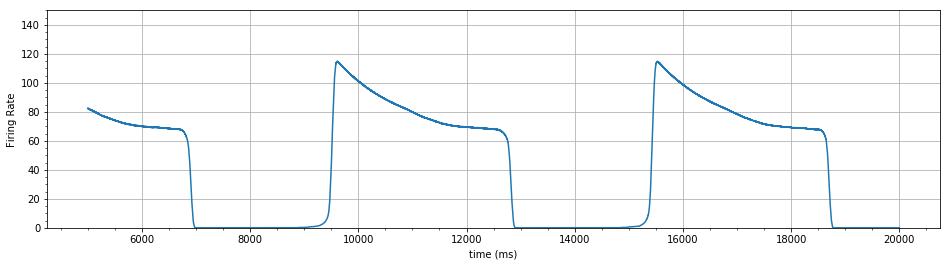

In [43]:
#PostI
plot_vars(PostI_statemon, PostI_rate, n, m, show_variables = False)

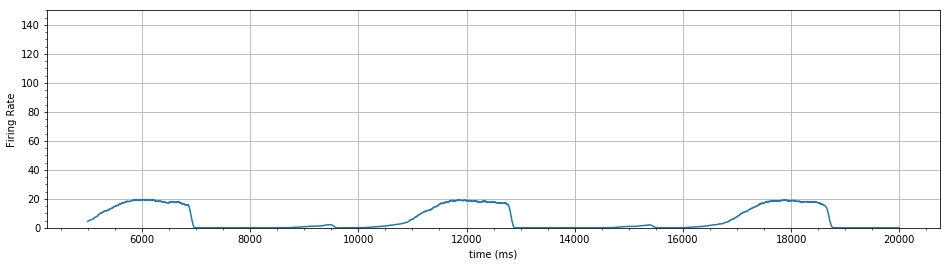

In [44]:
#AugE
plot_vars(AugE_statemon, AugE_rate,  n, m, show_variables = False)

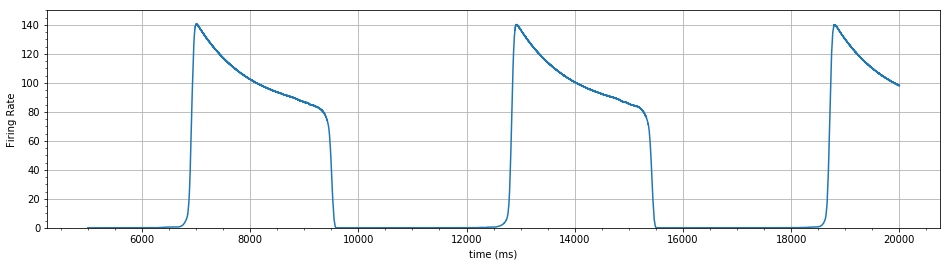

In [45]:
#EarlyI1
plot_vars(EarlyI1_statemon, EarlyI1_rate,  n, m, show_variables = False)

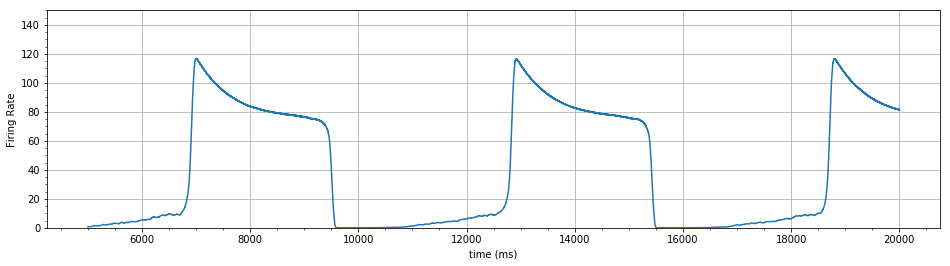

In [46]:
#PreI
plot_vars(PreI_statemon, PreI_rate, n, m, show_variables = False)

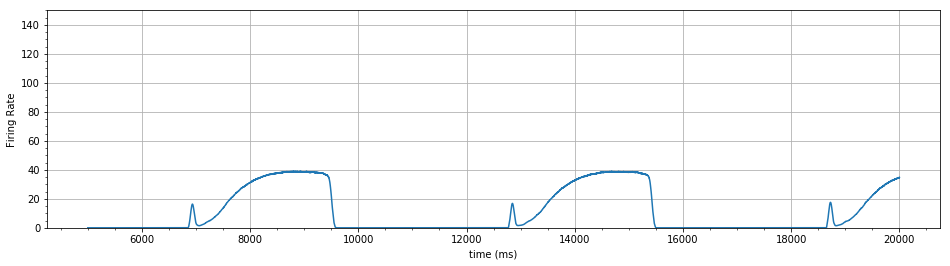

In [47]:
plot_vars(RampI_statemon, RampI_rate,  n, m, show_variables = False)

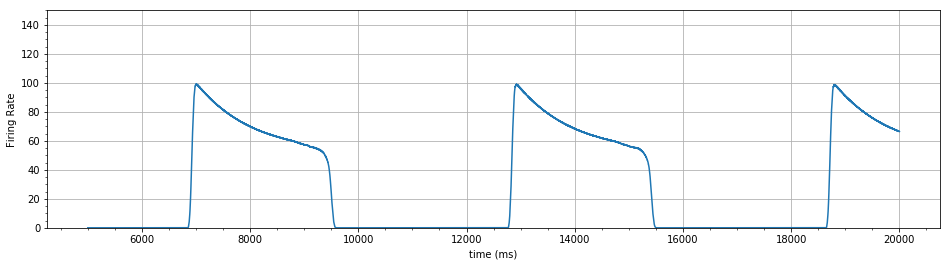

In [48]:
plot_vars(EarlyI2_statemon, EarlyI2_rate,  n, m, show_variables = False)

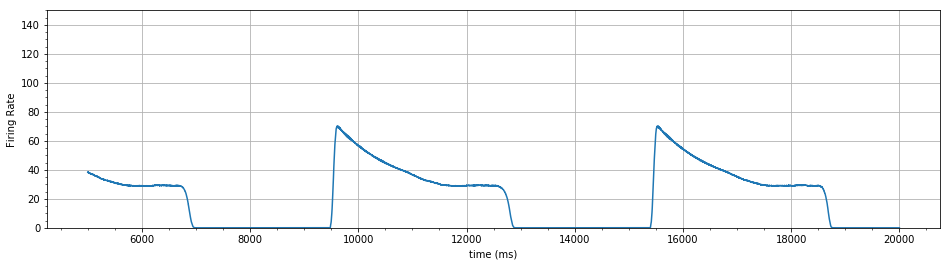

In [49]:
plot_vars(PostI_e_statemon, PostI_e_rate, n, m, show_variables = False)

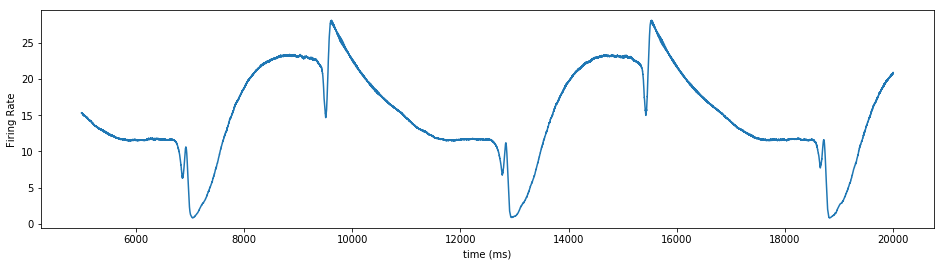

In [50]:
#CVN
#2/3 PostI_e 1/3 rampI
output_cVN = (2.0/5.0)*PostI_e_rate.smooth_rate(window='gaussian', width= 30*ms)/Hz+(3.0/5.0)*RampI_rate.smooth_rate(window='gaussian', width= 30*ms)/Hz
figure(figsize=(16,4))
plot(PreI_statemon.t[int(duration*n*10):int(duration*m*10)]/ms, output_cVN[int(duration*n*10):int(duration*m*10)])
xlabel('time (ms)')
ylabel('Firing Rate')
# ylim([0,60])
show()

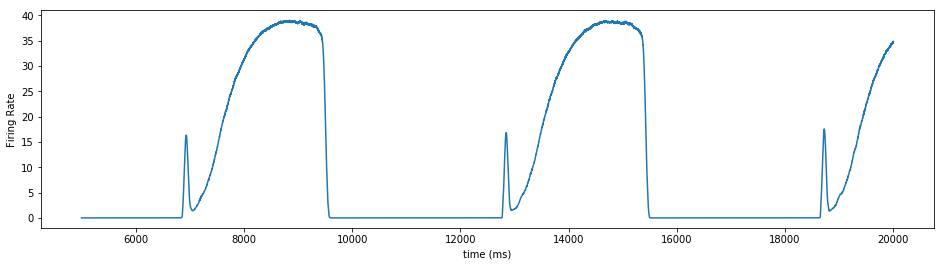

In [51]:
#PN
output_PN = RampI_rate.smooth_rate(window='gaussian', width= 30*ms)/Hz
figure(figsize=(16,4))
plot(PreI_statemon.t[int(duration*n*10):int(duration*m*10)]/ms, output_PN[int(duration*n*10):int(duration*m*10)])
xlabel('time (ms)')
ylabel('Firing Rate')
# ylim([0,60])
show()

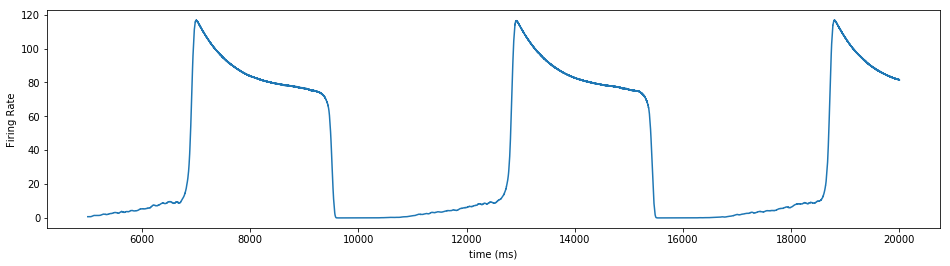

In [52]:
#HN
output_HN = PreI_rate.smooth_rate(window='gaussian', width= 30*ms)/Hz
figure(figsize=(16,4))
plot(PreI_statemon.t[int(duration*n*10):int(duration*m*10)]/ms, output_HN[int(duration*n*10):int(duration*m*10)])
xlabel('time (ms)')
ylabel('Firing Rate')
# ylim([0,60])
show()

